## CONTRIBUTION OF MITOCHONDRIAL DNA HETEROPLASMY TO THE PHENOTYPIC VARIABILITY IN MATERNALLY TRANSMITTED 22q11.2 DELETION SYNDROME
>Boris Rebolledo-Jaramillo<sup>1</sup>, Maria Gabriela Obregon<sup>2</sup>, Victoria Huckstadt<sup>2</sup>, Abel Gomez<sup>2</sup>, Gabriela M. Repetto<sup>1</sup>
> 1. Center for Genetics and Genomics, Facultad de Medicina Clínica Alemana, Universidad del Desarrollo, Santiago, Chile.
> 2. Servicio de Genética, Hospital de Pediatría Garrahan, Buenos Aires, Argentina.

> Funding: ANID FONDECYT 3170280 and 1171014

### DESCRIPTION

> This Jupyter notebook applies some of the analytical strategies shown in Rebolledo-Jaramillo, Su,  et al (2014) *Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy*  [**PNAS October 28, 2014 vol. 111 no. 43 15474-15479**](http://www.pnas.org/content/111/43/15474.abstract) to a newer set of 15 families, representing 17 mother-child pairs, to answer a different biological question related to mitochondrial DNA heteroplasmy.

#### CONDA DEPENDENCIES

>**channels**: bioconda, r , defaults, conda-forge  
>**dependencies**: r-base, jupyter, numpy, pandas, tzlocal, simplegeneric, rpy2, biopython, r-shape, pysam, scipy, r-rcolorbrewer, r-ape, r-pwr  

In [1]:
import re
import os
import pysam
import itertools
import pandas as pd
import numpy as np
from scipy.stats import poisson

In [2]:
%load_ext rpy2.ipython

### Define input/output

In [3]:
allelecounts = "./input/2020_01_27_argentina_raw_mtDNA_counts.txt"
relationship = "./input/2020_01_27_argentina_sample_relationship.txt"
haplogrepres = "./input/2020_01_27_argentina_mtDNA_haplogrep.txt"
samphenotype = "./input/2020_01_27_argentina_sample_phenotypes.txt"

outdir = "./output"
phylo = "./output/phylorelatives/"

if not os.path.exists(outdir):
    os.makedirs(outdir)
else:
    pass

if not os.path.exists(phylo):
    os.makedirs(phylo)
else:
    pass

# These samples were excluded because the pair does not match deletion size
exclude = ["DG236", "DG237"]
#exclude = []

### Read in allele counts

In [4]:
with open(allelecounts) as ac:
    first_line = ac.readline()
    if first_line.startswith("#"):
        df = pd.read_csv(allelecounts, sep='\t')
    else:
        df = pd.read_csv(allelecounts, sep='\t', header=None)

df.columns=["sample","reference","position","A","C","G","T","a","c","g","t",
            "depth","nalleles","major","minor","maf", "nt_bias"]

bias = [float(i) for i in (df[["nt_bias"]].replace(".", 10))['nt_bias']]

df.drop(labels=['nt_bias'], inplace=True, axis=1)
df['nt_bias'] = bias

df = df[~df["sample"].isin(exclude)]
df.reset_index(inplace = True, drop = True)

df.head(2)

,sample,reference,position,A,C,G,T,a,c,g,t,depth,nalleles,major,minor,maf,nt_bias
0,DG132,MT,1,0,0,12852,0,0,0,131,0,12983,1,G,.,0.0,10.0
1,DG132,MT,2,12300,0,0,0,119,0,0,0,12419,1,A,.,0.0,10.0


### Read in mother-child relationship codex

In [5]:
codex = pd.read_csv(relationship, sep="\t")
codex = codex[~codex["sample"].isin(exclude)]
codex.reset_index(inplace = True, drop = True)
codex.head(2)

,sample,relationship,family
0,DG18,C,1
1,DG213,M,1


### Make dataframes available in R

In [6]:
%R -i df -i codex

In [7]:
%%R
#Make sure samples in codex match samples in data
clean_codex <- codex[codex$sample %in% unique(df$sample),]
df$sample <- factor(df$sample, levels=clean_codex$sample)

### Number of mtDNA positions captured per sample

In [8]:
%%R
data.frame(table(df$sample))

    Var1  Freq
1   DG18 16305
2  DG213 16371
3   DG33 16262
4   DG34 16262
5  DG250 16264
6   DG60 16308
7  DG233 16262
8   DG76 16316
9  DG132 16369
10 DG133 16296
11 DG139 16263
12 DG161 16264
13 DG179 16342
14 DG180 16268
15 DG185 16458
16 DG184 16267
17 DG193 16264
18 DG221 16262
19 DG220 16262
20 DG222 16263
21 DG224 16265
22 DG225 16264
23 DG231 16394
24 DG232 16418
25 DG242 16516
26 DG243 16535
27 DG246 16263
28 DG247 16264
29 DG249 16365
30 DG248 16568


In [9]:
%%R
# 5-number summary of number of positions captured
summary(data.frame(table(df$sample))$Freq)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  16262   16263   16268   16326   16368   16568 


In [10]:
%%R
# Standard deviation for the number of mtDNA positions captured
sd(data.frame(table(df$sample))$Freq)

[1] 90.67677


### Supplementary figure 1
> **Per sample mtDNA sequencing depth distribution**. Samples are colored according to familial relationship.

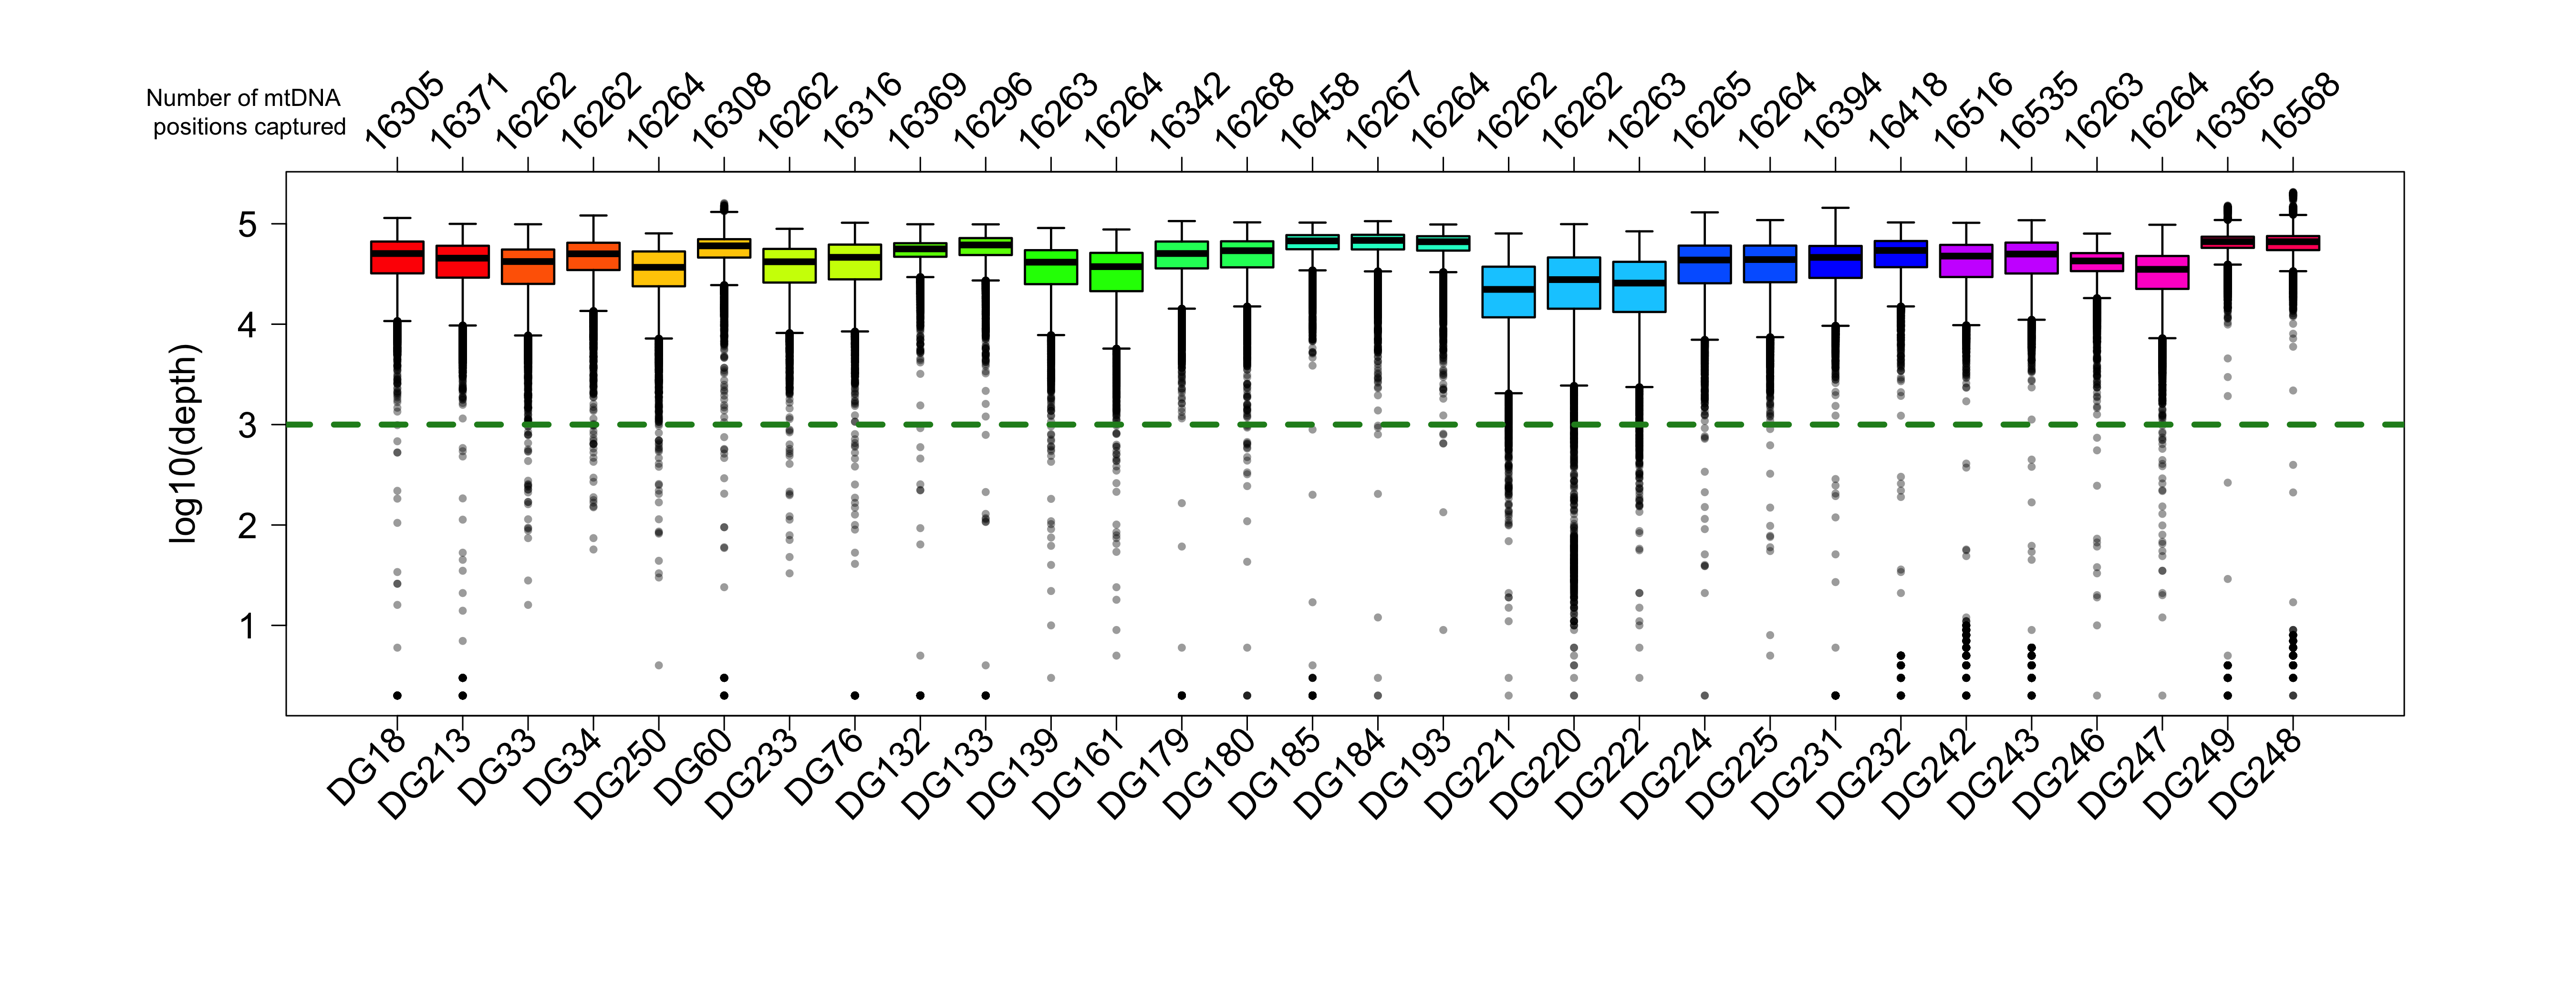

In [11]:
%%R  -w 18 -h 7 -u in -r 300
par(oma=c(2,2,2,2), mar=c(8,8,4,4))

bp = boxplot(log10(depth+1) ~ as.factor(sample), data=df,
       pch=16, outcol=rgb(0,0,0,100,maxColorValue=255),
       whiskltype=1, las=2, col=rainbow(15)[clean_codex$family], lwd=1.5, cex=0.75,
       cex.axis=1.5, xlab="", ylab="log10(depth)", cex.lab=1.5, xaxt="n")
abline(h=log10(1000), col='forestgreen', lwd=4, lty=2)

axis(1, at=1:length(bp$names),label=FALSE)
text((1:length(bp$names))+0.3, par("usr")[1] + 0.6, labels = bp$names, srt = 45, pos = 2, xpd = TRUE, cex=1.5)

axis(3, at=1:length(bp$n),label=FALSE)
text(1:length(bp$n), par("usr")[4] + 0.8, labels = bp$n, srt = 45, pos = 1, xpd = TRUE, cex=1.5)

text(par("usr")[1]-0.6,par("usr")[4]+0.6, labels="Number of mtDNA \n positions captured", xpd=TRUE)

### Supplementary figure 2
> **Supplementary figure 2. Per mtDNA position depth distribution.** Each position in the human mtDNA (16,569 positions) is represented by a boxplot according to the colors indicated in the legend.

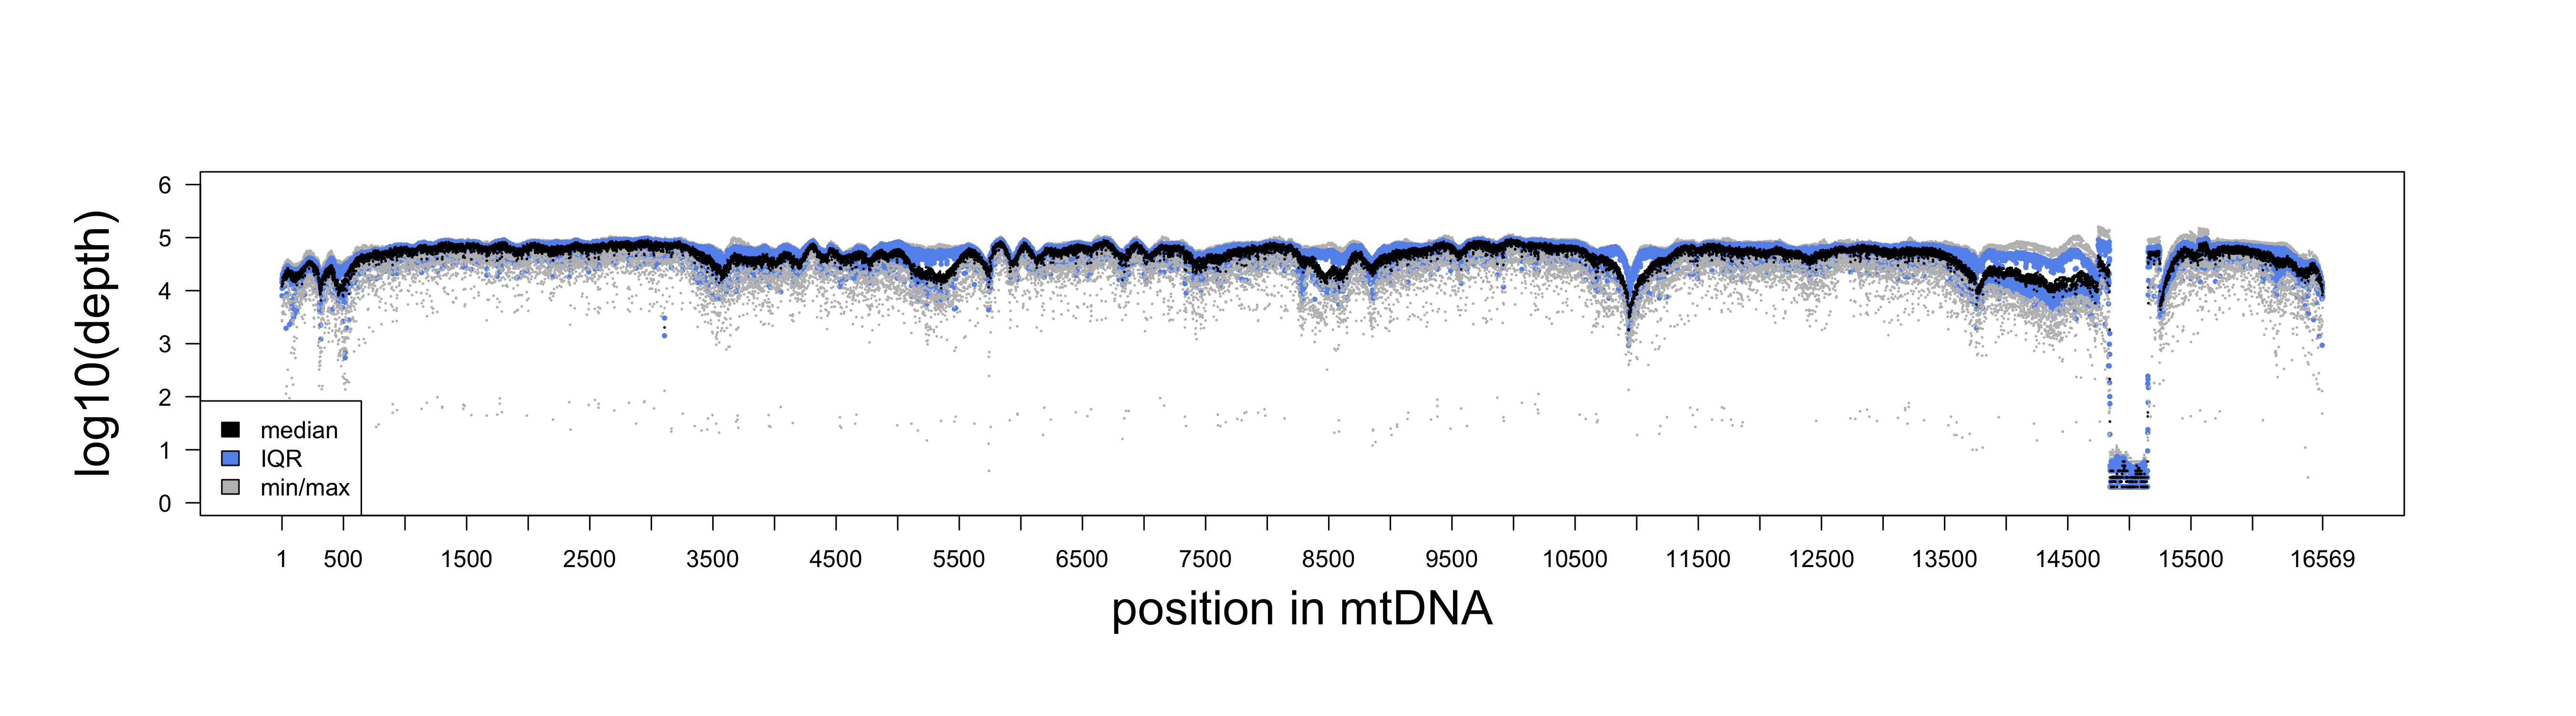

In [12]:
%%R  -w 18 -h 5 -u in -r 300
par(oma=c(2,2,2,2), mar=c(5,5,4,4))

bx <- boxplot(depth ~ as.factor(position), data=df, plot=F)
plot(1:length(bx$names), log10(bx$stats[2,]+1), pch=16, cex=0.5, col="cornflowerblue",xaxt="n",
    xlab="position in mtDNA", ylab="log10(depth)", cex.lab=2, cx.axis=2, las=2,ylim=c(0,6))


points(1:length(bx$names), log10(bx$stats[1,]+1), pch=16, cex=0.25, col="gray")
points(1:length(bx$names), log10(bx$stats[5,]+1), pch=16, cex=0.25, col="gray")
points(1:length(bx$names), log10(bx$stats[4,]+1), pch=16, cex=0.5, col="cornflowerblue")
points(1:length(bx$names), log10(bx$stats[3,]+1), xaxt="n", pch=16, cex=0.25)

axis(1, at=c(1,seq(500,16000,500),16569))
legend("bottomleft", legend=c("median", "IQR", "min/max"), fill=c("black", "cornflowerblue","gray"))

### Median depth per sample

In [13]:
depth_median = []
for i,frame in df.groupby("sample"):
    depth_median.append(np.median(frame.depth))
print(np.median(depth_median))

47004.75


### Haplogroups and sample maternal relatioships

In [14]:
def makeMajor(d):
    '''From the sample dataframe d 
    it creates a string of Ns of length 16569
    and replaces each N by the corresponding
    major allele at a position or keeps the N'''
    
    seq = list("N"*16569)
    col = ["position", "major"]
    for pos, nt in d[col].values:
        seq[int(pos)-1] = str(nt)
    return ''.join(seq)

In [15]:
# Create each sample major allele sequence in FASTA format, 
# and concatenate them into a single multifasta file

myfasta = "./output/phylorelatives/2020_01_27_argentina_mtDNA.fasta"

if os.path.exists(myfasta):
    os.remove(myfasta)
    
fasta = open(myfasta, "a")
faseq = dict()

for sampleid, sampledf in df.groupby("sample"):
    majorseq = makeMajor(sampledf)
    faseq[sampleid] = majorseq
    fasta.write(">" + sampleid + "\n")
    fasta.write(majorseq + "\n")

fasta.close()

### Supplementary figure 3. 
> **Pairwise distance neighbor joining tree reflects maternal relationships.** The tree has been rooted with the Reconstructed Sapiens Reference Sequence (RSRS) (Behar et al., 2012).

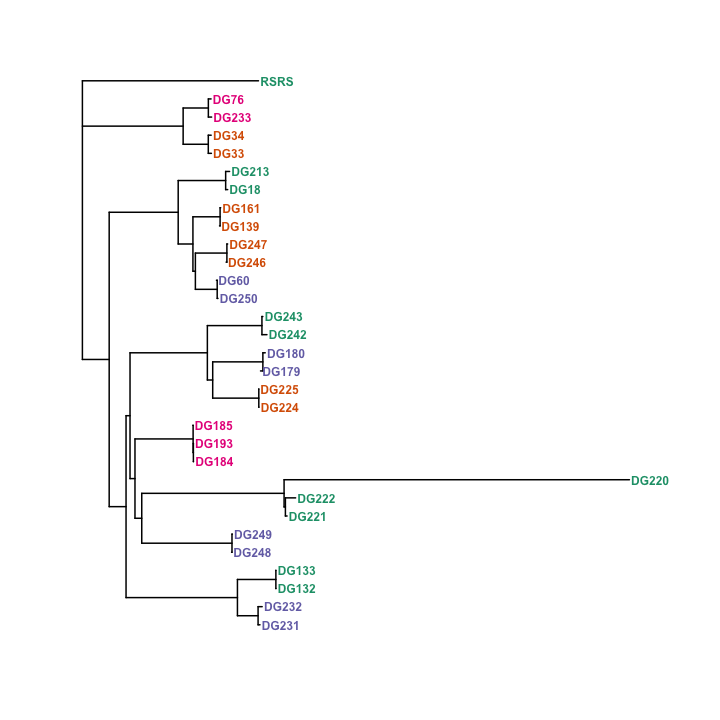

In [16]:
%%R -w 10 -h 10 -u in -r 72
library('ape')
library('RColorBrewer')


fa <- read.dna("output/phylorelatives/2020_01_27_argentina_mtDNA.fasta", format="fasta")
ref <- read.dna("input/phylorelatives/RSRS.fasta", format="fasta")

multi <- rbind(fa, ref)
d <- dist.dna(multi, model="raw", pairwise.deletion=T)

tree <- nj(d)
tree <- root(tree, outgroup="RSRS")


col =c()
for (id in tree$tip.label){
  col <- c(col,codex[codex$sample==id,3])
}

Colors = rep(brewer.pal(4, 'Dark2'),5)
plot(tree, cex=1, edge.width=2, label.offset=0.00002, tip.color=Colors[col], font=2)

### Supplementary table 1. 
> **mtDNA haplogroups.** We confirmed maternal relationships between mother-child pairs based on their haplogroup. Confidence: posterior probability of haplogroup assignment.

In [17]:
# Run Haplogrep on the ./phylorelatives/2020_01_27_argentina_mtDNA.fasta
# and download the "extended txt" to ./phylorelatives/2020_01_27_argentina_mtDNA_haplogrep.txt
# https://haplogrep.i-med.ac.at/app/index.html
# then read them in

haplogroups = pd.read_csv(haplogrepres, sep="\t")
haplogroups = haplogroups[~haplogroups["SampleID"].isin(exclude)]
haplogroups.reset_index(inplace = True)

pheno = pd.read_csv(samphenotype, sep='\t')
pheno = pheno[~pheno["mother"].isin(exclude)]
pheno.reset_index(inplace = True, drop = True)


tmp = pheno[['mother']]
tmp.columns = ["SampleID"]
motherHap = pd.merge(tmp, haplogroups[["SampleID","Haplogroup", "Overall_Rank"]])
motherHap.columns = ["mother","motherHap", "motherP"]


tmp = pheno[['child']]
tmp.columns = ["SampleID"]
childHap = pd.merge(tmp, haplogroups[["SampleID","Haplogroup", "Overall_Rank"]])
childHap.columns = ["child","childHap", "childP"]

haps = pd.concat([motherHap,childHap], axis=1, ignore_index = True)
haps.columns = ["Mother", "Hap_mother", "Conf_mother", "Child", "Hap_child", "Conf_child"]

child_order = codex[codex.relationship=="C"][["sample"]]
child_order.columns = ["Child"]

show_cols = ["Mother", "Child", "Hap_mother", "Conf_mother","Hap_child", "Conf_child"]
haps_table = child_order.merge(haps)[show_cols]
haps_table.index = range(1, len(haps_table) + 1)
haps_table

,Mother,Child,Hap_mother,Conf_mother,Hap_child,Conf_child
1,DG213,DG18,A2+(64)+@153,0.8748,A2+(64)+@153,0.8844
2,DG34,DG33,D1j1a,0.9431,D1j1a,0.9325
3,DG60,DG250,A2+(64),0.9656,A2+(64),0.9656
4,DG76,DG233,D1j1a1,0.9782,D1j1a1,0.9682
5,DG133,DG132,T2b3+151,0.9263,T2b3+151,0.9263
6,DG161,DG139,A2+(64),0.9337,A2+(64),0.9337
7,DG180,DG179,B2,0.7992,B2,0.7992
8,DG184,DG185,H3ao1,0.9259,H3ao1,0.9259
9,DG184,DG193,H3ao1,0.9259,H3ao1,0.9259
10,DG220,DG221,U1a1a3,0.6949,U1a1a3,0.8961


# Identification of high quality heteroplasmic sites

 ><i class="icon-pencil"> We defined high quality (HQ) sites:</i>
 >1. minor allele frequency (maf) ≥ 0.01
 >2. depth ≥ 1,000
 >3. strand bias ≤ 1.0
 >4. cycle bias ≤ 0.33
 >5. Poisson test P-value ≤ 0.05  
 >6. outside "problematic sites":
     - mtDNA homopolymeres
     - around the artificial "N" at position 3107
     - within 50 bp of the long range PCR primers 

### Power calculation to detect heteroplasmy at 1% when sampling at least 1000 reads

In [18]:
%%R
# Statistical power to detect a variable site with MAF≥1% from base error Phred BQ≤30
library("pwr")
pwr.2p.test(h = ES.h(0.01, 0.001), sig.level = 0.05, n=1000, alternative = "greater")


     Difference of proportion power calculation for binomial distribution (arcsine transformation) 

              h = 0.1370787
              n = 1000
      sig.level = 0.05
          power = 0.9222428
    alternative = greater

NOTE: same sample sizes



### Mask problematic sites

In [19]:
# We masked known homopolymers and positions around the location of the long range PCR primers

mask = [(303,311),(16184,16193),(3105,3109), (14800,15200)]

maskRegions = list()
for start,end in mask:
    maskRegions+=range(start,end+1)
    
# and apply initial filters

hq_sites_tmp = df[(df.maf>=0.01) & (df.depth>=1000) & (df.nt_bias<=1) & ~df.position.isin(maskRegions)]

### Site error rate

In [20]:
# We define a poisson test function that will take a single site, and explore the variability of
# the position among the remaining samples

def poisson_pval(current_df,sample):
    alleles = ['A','C','G','T','a','c','g','t']
    
    tmp1 = list(current_df.loc[current_df['sample']==sample, alleles].iloc[0,:])
    sample_counts = [a+b for (a,b) in zip(tmp1[:4],tmp1[4:])]
    
    tmp2 = list(current_df.loc[current_df['sample']!=sample, alleles].apply(sum,axis=0))
    others_counts = [a+b for (a,b) in zip(tmp2[:4],tmp2[4:])]
    
    sample_coverage = sum(sample_counts)
    
    observed_error = (sum(others_counts) - max(others_counts))/float(sum(others_counts))
    sample_nonMajor_counts = int(sample_coverage - max(sample_counts))
    
    pvalue = poisson.pmf(sample_nonMajor_counts, observed_error*sample_coverage)
    
    return pvalue

In [21]:
# We calculate a Poisson test for all variable sites, and add the p-value as a column
poisson_pvalues = []

for sample, position in hq_sites_tmp[["sample","position"]].itertuples(index = False):
    poisson_pvalues.append(poisson_pval(df[df['position'] == position], sample))

hq_sites_tmp.insert(len(hq_sites_tmp.columns), "poisson", poisson_pvalues, True)

### Cycle bias

In [22]:
# We define a function to calculate the proportion of times the variant allele is supported by a nt located
# within the edges of the read


def cycle_bias(pos,minor,bam,win=15):
    tot_minor_reads = 0
    minor_in_edge = 0
    samfile = pysam.AlignmentFile(bam,"rb")
    
    for pileupcolumn in samfile.pileup('MT', int(pos)-1, int(pos), stepper='all',
                                       max_depth=10000000, mask=False,truncate=True):
        if pileupcolumn.pos == int(pos)-1:
            for pileupread in pileupcolumn.pileups:
                if pileupread.alignment.mapping_quality >=20:
                
                    position_in_segment = pileupread.query_position
                    aligned_segment = pileupread.alignment
                    
                    if position_in_segment is not None:
                
                        segment_minor = aligned_segment.query_sequence[position_in_segment]
                        segment_qual = aligned_segment.query_qualities[position_in_segment]
                        
                        if segment_minor == minor and segment_qual >=30:

                            tot_minor_reads += 1
                            rlen = aligned_segment.query_length
                            edges = list(range(0, win)) + list(range(rlen - win, rlen + 1))
            
                            if position_in_segment in edges:
                                minor_in_edge += 1
    try:
        ratio = minor_in_edge/float(tot_minor_reads)
    except:
        ratio = np.nan
    return ratio

In [23]:
# This directory contains extracted reads in BAM format for all sites in the hq_sites_tmp table 
checkdir = "./input/check_sites"

# Then we calculate the cycle bias and add it as a column
cycle = []

for sample, position, minor in hq_sites_tmp[["sample", "position", "minor"]].itertuples(index=False):
    bam = "%s/%s_%d.bam" % (checkdir, sample, position)
    cycle.append(cycle_bias(position, minor, bam))
    
hq_sites_tmp.insert(len(hq_sites_tmp.columns), "cycle_bias", cycle, True)

In [24]:
# Finally, we filter out sites not passing the cycle bias or Poisson test.

hq_sites = hq_sites_tmp[(hq_sites_tmp.poisson <= 0.05) & (hq_sites_tmp.cycle_bias <= 0.33)]
hq_sites.to_csv("output/2020_01_27_argentina_hq_sites.txt", header=True, sep="\t", index=False)

del hq_sites_tmp

# Screening for contamination
> In our previous publication, Dickins, Rebolledo-Jaramillo, et al (2014) Controlling for contamination in resequencing studies with a reproducible web-based phylogentic approach [BioTechniques, 56(3):134–141](http://goo.gl/jv2J34), we described signs of potential contamination:
 1. Many heteroplasmic sites (≥5 per sample)
 2. Tigh minor allele frequency distribution (small variance)
 3. Non-family related positions

In [25]:
# Make R aware of the hq_sites dataframe
%R -i hq_sites

In [26]:
%%R
# Adjust value types in the hq_sites dataframe
tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))

In [27]:
%%R
# Median number of heteroplasmic sites per sample
summary(c(data.frame(table(hq_sites[["sample"]]))$Freq,rep(0,32-18)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.8667  1.0000  5.0000 


### Supplementary figure 4. 
> **Minor allele frequency distribution of samples with heteroplasmic sites.** MAF: Minor allele frequency.

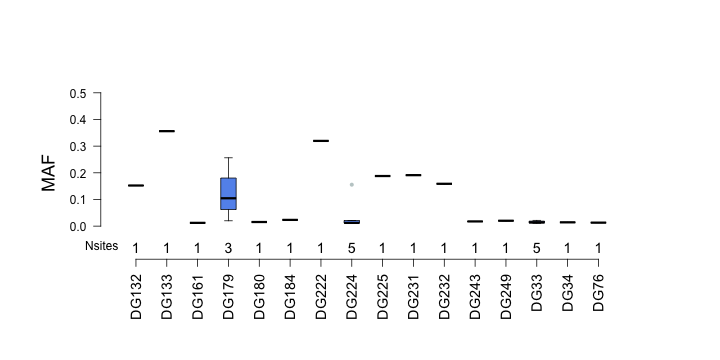

In [28]:
%%R  -w 10 -h 5 -u in -r 72
par(oma=c(2,2,2,2), mar=c(5,5,4,4))

# Plot hq_sites number of sites and minor allele frequency distribution

boxplot(
  maf~sample,
  data=hq_sites,
  pch=16,cex=0.75,
  outcol="azure3",outline=T,
  whisklty=1,whiskwd=1.5,
  staplelwd=1,
  boxwex=0.5,boxcol="black",boxfill="cornflowerblue",
  horizontal=F,cex.axis=1.2,las=2, yaxt="n",
  frame=F,ylim=c(-0.1,0.5), xlab="", ylab="MAF", cex.lab=1.5
  )


axis(2, at=c(0,seq(10,50,10)/100), las=2)


nsites = table(hq_sites[["sample"]])
for (i in 1:length(nsites)){
  text(i,-0.08, lab=nsites[i],cex=1.2)
}
mtext("Nsites",side=1,line=-1.5,at=0.7,adj=1.25)

### Supplementary figure 5
> **Minor allele sequences cluster with expected related sequences.** Samples DG33 and DG224, both had 5 heteroplasmic sites each with minor allele frequencies, but they do not cluster with unrelated sequences.

In [29]:
# For each sample with heteroplasmic sites, create
# a minor allele sequence replacing the major allele
# for the minor allele at the heteroplasmic position

for sampleid, sampledf in hq_sites.groupby("sample"):
    change = sampledf[["position","minor"]]
    minorseq = list(faseq[sampleid])
    for pos, minor in change.values:
        minorseq[int(pos)-1] = minor
    faseq[sampleid+"_minor"] = ''.join(minorseq)
    
for sampleid in [k for k in faseq.keys() if k.endswith('_minor')]:
    myfasta = "output/phylorelatives/" + sampleid + ".fasta"
    if os.path.exists(myfasta):
        os.remove(myfasta)
    
    f = open(myfasta, "w+")
    f.write(">" + sampleid + "\n")
    f.write(faseq[sampleid] + "\n")
    f.close()

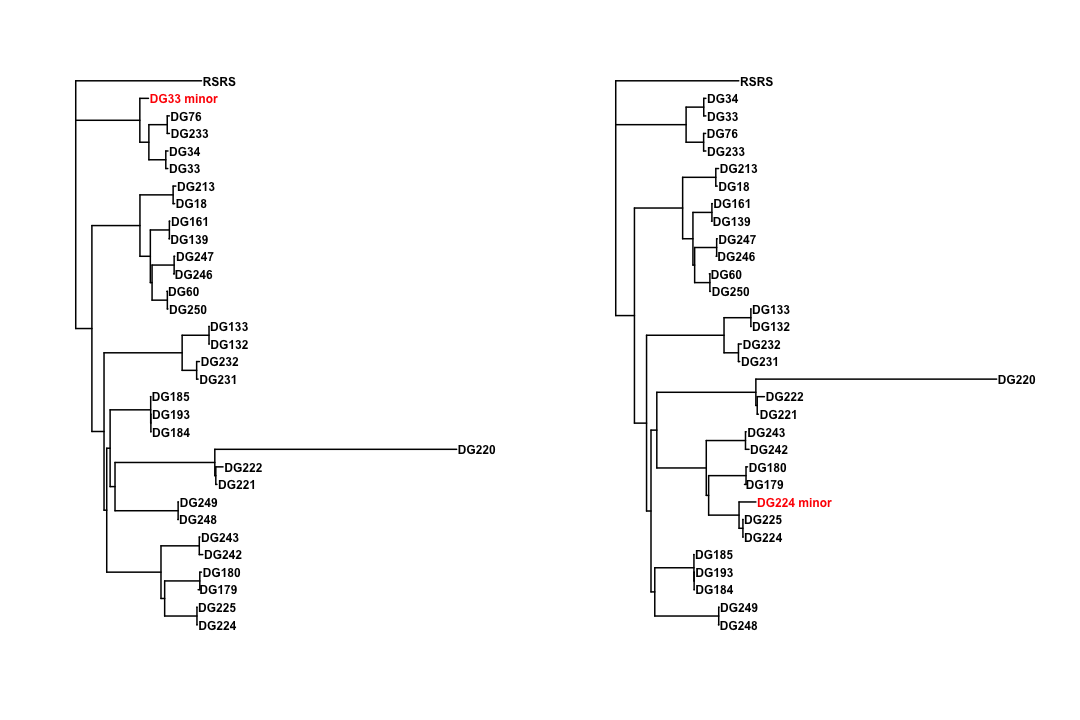

In [30]:
%%R -w 15 -h 10 -u in -r 72
library('ape')
library('RColorBrewer')

check = c("DG33", "DG224")
par(mfrow=c(1,length(check)))

for (i in 1:length(check)){
    myminorfasta <- paste0("./output/phylorelatives/", check[i], "_minor.fasta")
    mytiplabel <- paste0(check[i], "_minor")
    
    fa <- read.dna("./output/phylorelatives/2020_01_27_argentina_mtDNA.fasta", format="fasta")
    ref <- read.dna("./input/phylorelatives/RSRS.fasta", format="fasta")
    minor <-read.dna(myminorfasta, format="fasta")

    multi <- rbind(fa, ref, minor)
    d <- dist.dna(multi, model="raw", pairwise.deletion=T)

    tree <- nj(d)
    tree <- root(tree, outgroup="RSRS")

    plot(tree, cex=1, edge.width=2, label.offset=0.00002, font=2, tip.color = 1 + (tree$tip.label == mytiplabel))
  
}

### Table 2. High quality heteroplasmic sites. 
> M.A.F: minor allele frequency. P-value: Poisson test comparing error rate and frequency.

In [31]:
# Annotation with mvTool - Universal mtDNA Variant Converter and One Stop Annotation 
#https://mseqdr.org/mvtool.php

sites = list()
for r,v in hq_sites[["position","major", "minor"]].iterrows():
    sites.append("%d%s" % (v[0], v[1]))
    sites.append("%d%s" % (v[0], v[2]))
sites = list(set(sites))

infile = "./output/annotate_hq_sites.txt"
outfile = "./output/mseqdr.json"

if os.path.isfile(infile):
    pass
else:
    pd.DataFrame(sites).to_csv("./output/annotate_hq_sites.txt", 
                           header=False, sep="\t", index=False )
if os.path.isfile(outfile):
    pass
else:
    command = "curl -s -X POST https://mseqdr.org/mtannotapi.php?format=classical --data-binary @./output/annotate_hq_sites.txt  -o ./output/mseqdr.json"
    os.system(command)

mseqdr = pd.DataFrame(list(pd.read_json("./output/mseqdr.json")["mseqdr"]))
general = pd.DataFrame(list(pd.read_json("./output/mseqdr.json")["general"]))

In [32]:
from Bio import SeqIO
from Bio.Seq import Seq

In [33]:
rCRS = SeqIO.read(open("./input/rCRS.genebank.gb","r"), "genbank")

genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [34]:
def translate(sequence,gene):
    if len(str(sequence))%3!=0:
        add = 3 - (len(str(sequence))%3)
    else:
        add = 0

    if genedb[gene]["strand"]==1:
        modseq=str(sequence)+add*'A'        
    else:
        modseq=str(sequence.reverse_complement())+add*'A'

    try:
        translation=str(Seq(modseq).translate(table=2,cds=True))
    except:
        translation=[]

    return translation

In [35]:
def evoImpact(heteroplasmic_site):
    pos, major, minor = heteroplasmic_site
    position  = int(pos)-1
    gene_match = [g for g in genedb if position in list(range(genedb[g]['start'], genedb[g]['end']))]
    
    if gene_match:
        gene = gene_match[0]
    else:
        gene = "intergenic"
    
    ntClass = {'pu':['A','G'],'py':['C','T']}
    majorClass = [k for k,v in ntClass.items() if major in v]
    minorClass = [k for k,v in ntClass.items() if minor in v]
    
    if majorClass == minorClass:
        ntimpact = 'ts'
    else:
        ntimpact = 'tv'
    
    try:
        if gene in [feature.qualifiers['gene'][0] for feature in rCRS.features if feature.type=="CDS"]:

            majorseq = rCRS.seq.tomutable()
            minorseq = rCRS.seq.tomutable()
            majorseq[position] = major
            minorseq[position] = minor
            ref_seq = rCRS.seq[genedb[gene]["start"]:genedb[gene]["end"]]
            major_seq = majorseq[genedb[gene]["start"]:genedb[gene]["end"]]
            minor_seq = minorseq[genedb[gene]["start"]:genedb[gene]["end"]]

            if (translate(major_seq,gene)==translate(minor_seq,gene)):
                ptimpact = "syn"
            else:
                ptimpact = "nonsyn"
        else:
            ptimpact = "-"
            
        return pd.Series([gene, ptimpact, ntimpact])

    except:
        ptimpact = "-"
        return pd.Series(["intergenic", ptimpact, ntimpact])

In [36]:
# Calculate impact and annotate

evo_class = hq_sites[["position","major","minor"]].apply(evoImpact, axis=1)
evo_class.columns = ["gene", "pt_effect", "nt_effect"]
annotated = pd.concat([hq_sites[["sample", "position", "major", "minor", "maf", "depth", "poisson"]], evo_class], axis=1).sort_values(by=["sample", "position"])
annotated.replace("D-loop[12]", "Dloop", regex=True, inplace=True)
annotated = annotated.merge(codex).sort_values(by=["family","sample", "position"])
annotated.reset_index(inplace = True, drop = True)

In [37]:
# Extract annotations from database tables

db1 = list()
db2 = list()
col1 = ['HGVS_g', 'Mitomap_Disease','Mitomap_status']
col2 = ['dbSNP','ClinVar_ClinicalSignificance','ClinVar_Disease']
for i, row in annotated[["position", "major", "minor"]].iterrows():
    pos, major, minor = row
    key1 = "%d%s" % (pos, major)
    key2 = "%d%s" % (pos, minor)
    db1.append(mseqdr[(mseqdr.Input == key1) | (mseqdr.Input == key2)][col1].values.flatten().tolist())
    db2.append(general[(general.Input == key1) | (general.Input == key2)][col2].values.flatten().tolist())

db = pd.concat([pd.DataFrame(db1),pd.DataFrame(db2)], axis = 1)
db.columns = col1 + col2

In [38]:
pd.concat([annotated, db], axis = 1).style.hide_columns(['nt_effect','relationship', 'family', 'HGVS_g','ClinVar_ClinicalSignificance', 'ClinVar_Disease']).format({'maf':'{:.3f}','poisson':'{:.3f}' })

,sample,position,major,minor,maf,depth,poisson,gene,pt_effect,Mitomap_Disease,Mitomap_status,dbSNP
0,DG33,10873,C,T,0.014,11859,0.000,ND4,syn,-,-,rs2857284
1,DG33,14668,T,C,0.011,4713,0.000,ND6,syn,Depressive Disorder associated,Reported,rs28357678
2,DG33,14783,C,T,0.011,13425,0.000,CYTB,syn,-,-,rs28357680
3,DG33,15301,A,G,0.019,10341,0.000,CYTB,syn,-,-,rs28573847
4,DG33,15326,A,G,0.022,14117,0.000,CYTB,nonsyn,-,-,rs2853508
5,DG34,6802,A,G,0.014,37167,0.000,COX1,nonsyn,-,-,-
6,DG76,15786,T,C,0.013,66261,0.000,CYTB,nonsyn,-,-,-
7,DG132,9507,T,C,0.152,55188,0.000,COX3,nonsyn,-,-,-
8,DG133,9507,T,C,0.356,61348,0.000,COX3,nonsyn,-,-,-
9,DG161,5492,T,C,0.012,29462,0.000,ND2,syn,-,-,rs377109345


In [39]:
# Absolute frequency per gene/region
annotated.gene.value_counts()

CYTB     6
Dloop    5
COX3     3
ND1      2
ND2      2
COX1     2
ND4      1
RNR1     1
ND6      1
TRNL2    1
ND3      1
ND5      1
Name: gene, dtype: int64

In [40]:
# Absolute frequency of synonsynous and non synonymous variants
annotated.pt_effect.value_counts()

nonsyn    12
syn        7
-          7
Name: pt_effect, dtype: int64

In [41]:
# Absolute frequency of transitions (ts) and transversins (tv)
annotated.nt_effect.value_counts()

ts    24
tv     2
Name: nt_effect, dtype: int64

In [42]:
%%R

# Two sided proportion test with Yates correction

row_names <- c("Dloop", "tRNA", "rRNA", "Syn", "Nonsyn", "Intergenic")
len_region <- c(1122, 1508, 2513, 2834, 8533, 88)
obs_counts <- c(5, 1, 1, 7, 12, 0)

mylist <- list()
for (i in 1:6){
    mylist[[row_names[i]]]  <- prop.test(x=obs_counts[i], n=29, p=len_region[i]/16569)$p.value
}

#round(unlist(mylist),3)
stats <- cbind(len_region, obs_counts, round((len_region/16569)*sum(obs_counts),1), round(unlist(mylist),3)) 
colnames(stats) <- c("bp", "Obs.", "Exp.", "p-value")
stats


             bp Obs. Exp. p-value
Dloop      1122    5  1.8   0.061
tRNA       1508    1  2.4   0.462
rRNA       2513    1  3.9   0.133
Syn        2834    7  4.4   0.448
Nonsyn     8533   12 13.4   0.366
Intergenic   88    0  0.1   1.000


## Comparison of concordant vs. discordant pairs

In [43]:
%%R
hq_sites$sample = factor(hq_sites$sample, levels=as.character(clean_codex$sample))

In [44]:
%%R
nsites = cbind(data.frame(table(hq_sites$sample)), clean_codex)
nsites <- nsites[nsites$Var1 == nsites$sample, c("sample", "Freq", "relationship", "family")]
write.table(nsites, "./output/2020_01_27_argentina_nsites.txt", sep="\t", quote=FALSE, row.names=F)

In [45]:
nsites = pd.read_csv("./output/2020_01_27_argentina_nsites.txt", sep="\t")
out = []
for mother, child in pheno[["mother", "child"]].itertuples(index=False):
    freq_mother = int(nsites[nsites["sample"] == mother].Freq)
    freq_child = int(nsites[nsites["sample"] == child].Freq)
    out.append((freq_mother,  freq_child))

pheno_sites = pd.concat([pheno, pd.DataFrame(out)], axis=1)
pheno_sites.columns = ["mother", "child", "Heart", "Palate", "n_mother", "n_child"]

In [46]:
child_order.columns = ["child"]
pheno_sites_tmp = child_order.merge(pheno_sites)
del pheno_sites
pheno_sites = pheno_sites_tmp

### Number of heteroplasmic sites per sample

In [47]:
pheno_sites[["mother", "child", "Heart", "Palate", "n_mother", "n_child"]]

,mother,child,Heart,Palate,n_mother,n_child
0,DG213,DG18,concordant,discordant,0,0
1,DG34,DG33,concordant,concordant,1,5
2,DG60,DG250,discordant,concordant,0,0
3,DG76,DG233,discordant,discordant,1,0
4,DG133,DG132,discordant,discordant,1,1
5,DG161,DG139,discordant,discordant,1,0
6,DG180,DG179,discordant,concordant,1,3
7,DG184,DG185,discordant,discordant,1,0
8,DG184,DG193,discordant,discordant,1,0
9,DG220,DG221,concordant,discordant,0,0


### Change in the number of sites

In [48]:
%%R

# This function calculates a permutation test on the Mann-Whitney U test statistic

boot_test <- function(organ, fam){
    
    set.seed(2020)

    concordant <- pheno_sites[pheno_sites[[organ]]=="concordant", fam]
    concordant <- concordant[!is.na(concordant)]
    discordant <- pheno_sites[pheno_sites[[organ]]=="discordant", fam]
    discordant <- discordant[!is.na(discordant)]
    
    ncon <- length(concordant)
    ndis <- length(discordant)
    
    obs <- wilcox.test(concordant, discordant)$statistic
    
    combined <- c(concordant, discordant)
    
    boot = 0
    for (i in 1:1000){
        
        newsample <- sample(combined, ncon+ndis, replace=FALSE)
        newcon <- newsample[1:ncon]
        newdis <- newsample[(ncon+1):(ncon+ndis)]
        newstat <- wilcox.test(newcon, newdis)$statistic
        #boot <- c(boot, newstat)
        if (newstat>=obs){
            boot <- boot + 1
        } else {
            boot <- boot + 0
        }
        
    }
    
    return(boot/1000) 
}

In [49]:
%%R -i pheno_sites

# We calculated the difference between the number of sites 
# observed in a mother and her child
pheno_sites$diff <- pheno_sites$n_child - pheno_sites$n_mother


mylist <- list()
row_names <- c()
for (organ in c("Heart", "Palate")){
    for (phen in c("concordant", "discordant")){
        name <- paste(organ, phen, sep="_")
        row_names <- c(row_names, name)
        
        dd <- pheno_sites[pheno_sites[[organ]] == phen,"diff"]
        summ <- as.vector(summary(dd, na.rm=T))
        shap <- shapiro.test(dd)$p
        n <- length(dd)
        mylist[[name]] <- c(n, summ, shap)
    }
}

nsites_stat <- data.frame(matrix(unlist(t(mylist)),4,8, byrow=TRUE))
rownames(nsites_stat) <- row_names
colnames(nsites_stat) <- c("N","Min", "Q1", "Median", "Mean", "Q3", "Max", "Shapiro")
round(nsites_stat,3)

                   N Min Q1 Median   Mean Q3 Max Shapiro
Heart_concordant   5   0  0      1  1.800  4   4   0.057
Heart_discordant  11  -1 -1      0 -0.182  0   2   0.010
Palate_concordant  7  -1  0      0  1.286  3   4   0.091
Palate_discordant  9  -1 -1      0 -0.222  0   1   0.025


In [50]:
%%R
# Boostrap wilcox test

print(paste("Delta N sites Concordant vs Discordant Heart pvalue = ", boot_test("Heart", "diff")))
print(paste("Delta N sites Concordant vs. Discordant Palate pvalue = ",boot_test("Palate", "diff")))

[1] "Delta N sites Concordant vs Discordant Heart pvalue =  0.012"
[1] "Delta N sites Concordant vs. Discordant Palate pvalue =  0.073"


### Allele frequency change 

In [51]:
family_id = dict(codex[['sample','family']].values)
family_info = dict()

for fam, d in codex.groupby('family'):
    mother = d[d['relationship'] == 'M']['sample'].values
    children = d[d['relationship'] != 'M']['sample'].values
    family_info[fam] = {'mother':mother, 'children':children}

In [52]:
out = []

for sample, position, minor in hq_sites[['sample', 'position', 'minor']].values:
    
    mother = family_info[family_id[sample]]['mother'][0]
    children = family_info[family_id[sample]]['children']
    
    tmp_mom = df[(df['sample'] == mother) & (df['position'] == position)]
    sum_mom = int(tmp_mom[minor.upper()] + tmp_mom[minor.lower()])
    maf_mom = float(sum_mom) / int(tmp_mom['depth'].values)
    
    for child in children:
        tmp_child = df[(df['sample'] == child) & (df['position'] == position)]
        sum_child = int(tmp_child[minor.upper()] + tmp_child[minor.lower()])
        maf_child = float(sum_child) / int(tmp_child['depth'].values)
        delta = maf_child - maf_mom
        bottleneck = ((maf_mom) * (1.0 - maf_mom)) / delta**2
        
        #print [mother, child, position, minor,maf_mom , maf_child, delta, bottleneck]
        out.append([mother, child, position, minor, 
                    sum_mom, int(tmp_mom['depth'].values), maf_mom, 
                    sum_child, int(tmp_child['depth'].values), maf_child, 
                    delta, bottleneck])

In [53]:
heteroplasmic_pairs = pd.DataFrame(out).drop_duplicates()
heteroplasmic_pairs.columns = ['mother', 'child', 'position', 'allele', 
                               'count_mom', 'depth_mom', 'af_mom', 
                               'count_child', 'depth_child', 'af_child', 
                               'delta', 'bottleneck']
#child_order.merge(heteroplasmic_pairs)[list(heteroplasmic_pairs.columns)]

In [54]:
mindp = 10

In [55]:
final_table = pd.merge(heteroplasmic_pairs, pheno, how='left', 
                       left_on=["mother","child"], 
                       right_on=["mother","child"])

out_cols = list(final_table.columns)
codex_children = codex[codex.relationship == "C"]
codex_children.columns = ["child", "relationship", "family"]
final_table_tmp = codex_children.merge(final_table).sort_values(by=["family", "position"])
del final_table
final_table = final_table_tmp[out_cols]

In [56]:
def highlight(x):
    if x.count_mom < mindp:
        return ['background-color: yellow'] * len(final_table.columns)
    else:
        return ['background-color: white'] * len(final_table.columns) 

In [57]:
final_table.reset_index(inplace = True, drop = True)
final_table.style.apply(highlight, axis=1)

,mother,child,position,allele,count_mom,depth_mom,af_mom,count_child,depth_child,af_child,delta,bottleneck,heart,palate
0,DG34,DG33,6802,G,529,37167,0.014233,1,43112,0.000023,-0.014210,69.485273,concordant,concordant
1,DG34,DG33,10873,T,7,9519,0.000735,170,11859,0.014335,0.013600,3.973072,concordant,concordant
2,DG34,DG33,14668,C,15,34435,0.000436,54,4713,0.011458,0.011022,3.584065,concordant,concordant
3,DG34,DG33,14783,T,11,23194,0.000474,143,13425,0.010652,0.010178,4.576443,concordant,concordant
4,DG34,DG33,15301,G,1,50276,0.000020,194,10341,0.018760,0.018740,0.056634,concordant,concordant
5,DG34,DG33,15326,G,2,47401,0.000042,307,14117,0.021747,0.021705,0.089561,concordant,concordant
6,DG76,DG233,15786,C,867,66261,0.013085,0,62238,0.000000,-0.013085,75.425606,discordant,discordant
7,DG133,DG132,9507,C,21847,61348,0.356116,8407,55188,0.152334,-0.203782,5.521627,discordant,discordant
8,DG161,DG139,5492,C,362,29462,0.012287,5,30038,0.000166,-0.012121,82.609860,discordant,discordant
9,DG180,DG179,150,T,298,19275,0.015460,4900,19122,0.256249,0.240789,0.262532,discordant,concordant


In [58]:
# De novo variants should be removed from the transmission analysis
denovo = list(final_table[final_table.count_mom < mindp ].index)
final_table = final_table[~final_table.index.isin(denovo)]
final_table.to_csv("./output/2020_01_27_argentina_final_results.txt", sep="\t", index=False)

In [59]:
%%R 
final_table = read.table("./output/2020_01_27_argentina_final_results.txt", header=TRUE, sep="\t", stringsAsFactors=FALSE)

In [60]:
%%R

# This function calculates a permutation test on the Mann-Whitney U test statistic

boot_test_2 <- function(concordant, discordant){
    
    set.seed(2020)

    ncon <- length(concordant)
    ndis <- length(discordant)
    
    obs <- wilcox.test(concordant, discordant)$statistic
    
    combined <- c(concordant, discordant)
    
    boot = 0
    for (i in 1:1000){
        
        newsample <- sample(combined, ncon+ndis, replace=FALSE)
        newcon <- newsample[1:ncon]
        newdis <- newsample[(ncon+1):(ncon+ndis)]
        newstat <- wilcox.test(newcon, newdis)$statistic
        #newstat <- t.test(newcon, newdis)$statistic
        #boot <- c(boot, newstat)
        if (newstat>=obs){
            boot <- boot + 1
        } else {
            boot <- boot + 0
        }
        
    }
    
    return(boot/1000) 
}

In [61]:
%%R

waterColor <- function(colorName, Alpha=100){
    return(rgb(matrix(col2rgb(colorName),1,3), alpha=Alpha, maxColorValue=255))
}

plotShift <- function(d1, d2, Title="", col_1="#8B0000", col_2="#008B8B", 
                      leg_1="Con.", leg_2="Dis."){
    labx <- expression(paste(Delta,"AF"))
    
    if (length(d1) < 10) {
        leg1 <- paste0("N=", length(d1), "   ", leg_1) 
    } else {
        leg1 <- paste0("N=", length(d1), " ", leg_1)
    }
    
    
    if (length(d2) < 10) {
        leg2 <- paste0("N=", length(d2), "   ", leg_2) 
    } else {
        leg2 <- paste0("N=", length(d2), " ", leg_2)
    }
    
    
    h0 <- hist(c(d1,d2), plot=F)
    #x0 <- max(c(abs(min(h0$breaks)), abs(max(h0$breaks)))) + 0.1
    x0 <- 1.0
    
    h1 <- hist(d1, plot=F, breaks=h0$breaks)
    h1$counts <- h1$counts/sum(h1$counts)
    
    h2 <- hist(d2, plot=F, breaks=h0$breaks)
    h2$counts <- h2$counts/sum(h2$counts)
    
    
    plotHist <- function(h, x, Col, Main=Title){
        plot(h, main=Main, xlab=labx, ylab="", col=Col, 
             border="white", axes=FALSE, cex.lab=1.5, 
             xlim=c(-x,x), ylim=c(0,1))
    }
    
    plotCurve <- function(d, x, Col){
        curve(dnorm(x, mean=mean(d), sd=sd(d)), add=NA, 
              col=Col, lwd=3, frame.plot=F, 
              axes=F, ylab="", xlab="",xlim=c(-x,x))   
    }
    
    
    plotHist(h1, x0, waterColor(col_1), Title )
    par(new=TRUE)
    plotHist(h2, x0, waterColor(col_2), Title)
    par(new=TRUE)
    plotCurve(d1, x0, col_1)
    par(new=TRUE)
    plotCurve(d2, x0, col_2)
    
    axis(1, lwd=2, cex.axis=1, at=seq(-x0, x0, 0.2), 
         labels=c("-1.0",rep("",4),0,rep("",4),"1.0"))
    legend("topleft", legend=c(leg1, leg2, paste0("p = ",boot_test_2(d1, d2) )), 
           bty="n", col=c(col_1, col_2, "white"), pch=15)
    
}

### Figure 1. Heteroplasmic allele frequency change (∆AF) between a mother and her child
> The histograms describe the actual distribution of the data, whereas the curves represent the expected density distribution provided each sample’s mean and standard deviation. The healthy values correspond to a set of 39 healthy mother-child pairs used to compute figure S14E in Rebolledo-Jaramillo et al 2014 PNAS October 28, 2014 111 (43) 15474-15479

In [62]:
expectation = pd.read_csv("./input/delta_avrgMAF_Rebolledo-Jaramillo_pnas2014_S14EFig.txt",
                        sep="\t", header=None)
expectation.columns = ["healthy"]

In [63]:
%R -i expectation

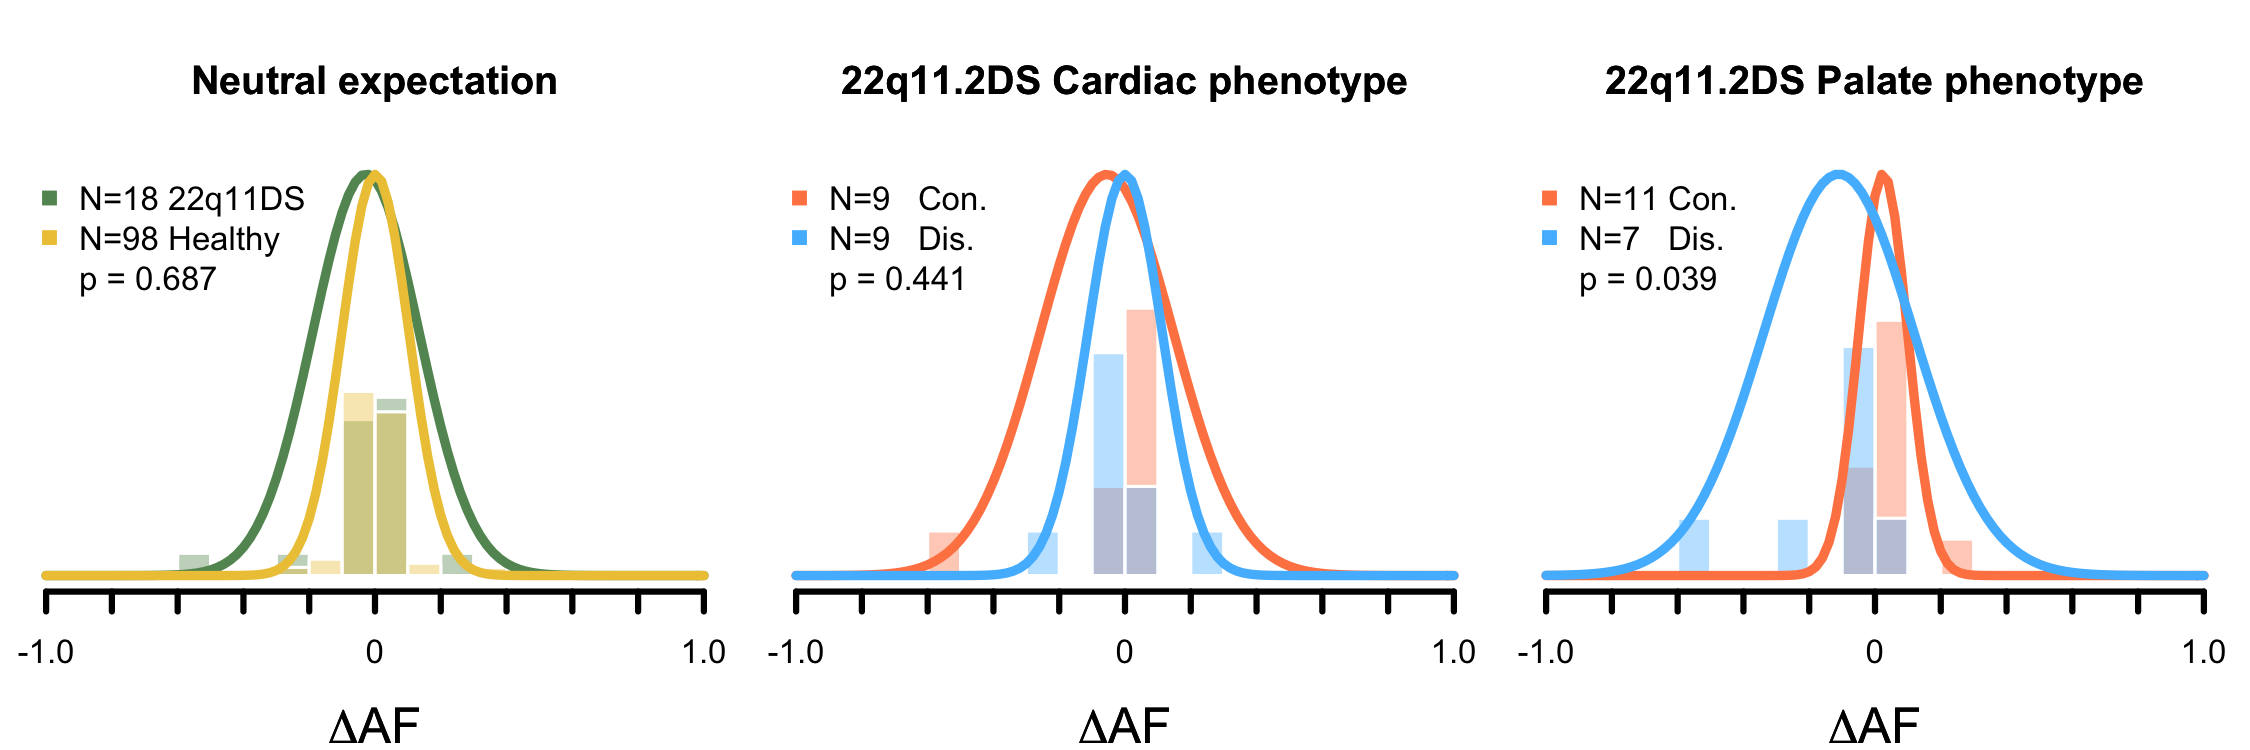

In [64]:
%%R -w 7.5 -h 2.5 -u in -r 300
par(mfrow=c(1,3))
par(mar=c(4,0.5,4,0.5))

heart_concordant <- final_table[final_table$heart=="concordant",]$delta
heart_discordant <- final_table[final_table$heart=="discordant",]$delta

palate_concordant <- final_table[final_table$palate=="concordant",]$delta
palate_discordant <- final_table[final_table$palate=="discordant",]$delta

colCon="#ff8552" # orange
colDis="#51bbfe" # blue

col1="#629460" # green
col2="#eec643" # yellow

plotShift(final_table$delta, expectation$healthy, "Neutral expectation", 
          col1, col2, "22q11DS", "Healthy")
plotShift(heart_concordant, heart_discordant, "22q11.2DS Cardiac phenotype", col_1=colCon, col_2=colDis)
plotShift(palate_concordant,palate_discordant, "22q11.2DS Palate phenotype", col_1=colCon, col_2=colDis)

In [65]:
%%R

mylist <- list()
row_names <- c()
for (organ in c("heart", "palate")){
    for (pheno in c("concordant", "discordant")){
        name <- paste(organ, pheno, sep="_")
        row_names <- c(row_names, name)
        mylist[[name]] <- final_table[final_table[[organ]] == pheno,]$delta
    }
}

value_stats <- function(x){
    
    n <- length(x)
    summ <- as.vector(summary(x))
    shap <- shapiro.test(x)
    return(c(n, summ, shap$p))
}

#lapply(mylist, value_stats)

delta_stats <- data.frame(matrix(unlist(t(lapply(mylist, value_stats))),4,8, byrow=TRUE))
rownames(delta_stats) <- row_names
colnames(delta_stats) <- c("N","Min", "Q1", "Median", "Mean", "Q3", "Max", "Shapiro")
round(delta_stats,3)


                   N    Min     Q1 Median   Mean     Q3   Max Shapiro
heart_concordant   9 -0.588 -0.014  0.009 -0.055  0.011 0.092   0.000
heart_discordant   9 -0.204 -0.023 -0.013  0.000  0.020 0.241   0.027
palate_concordant 11 -0.032 -0.005  0.010  0.025  0.015 0.241   0.000
palate_discordant  7 -0.588 -0.113 -0.023 -0.110 -0.013 0.092   0.012


In [66]:
%%R
newlist <- list()
newlist[["22q"]] <- final_table$delta
newlist[["Healthy"]] <- expectation$healthy

delta_stats <- data.frame(matrix(unlist(t(lapply(newlist, value_stats))),2,8, byrow=TRUE))
rownames(delta_stats) <- c("22q", "healthy")
colnames(delta_stats) <- c("N","Min", "Q1", "Median", "Mean", "Q3", "Max", "Shapiro")
round(delta_stats,3)

         N    Min     Q1 Median   Mean    Q3   Max Shapiro
22q     18 -0.588 -0.021 -0.004 -0.028 0.011 0.241       0
healthy 98 -0.440 -0.017 -0.004  0.001 0.018 0.409       0


### Alternative Fig. 1

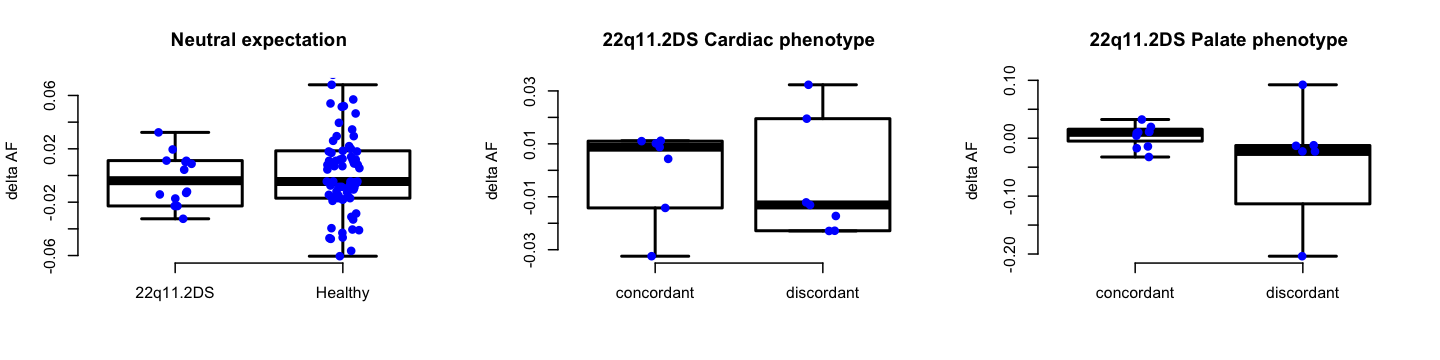

In [67]:
%%R -w 10 -h 2.5 -u in -r 144

par(mfrow=c(1,3))

d22q <- final_table$delta
expe <- expectation$healthy
label <- c(rep("Healthy",length(expe)), rep("22q11.2DS", length(d22q)))
data <- data.frame(delta = c(expe,d22q), condition = label)

boxplot(delta ~ condition, data=data,
       frame=F, outline=F, lty=1, lwd=2, xlab = "", main = "Neutral expectation", ylab = "delta AF")
stripchart(delta ~ label, vertical = TRUE, data = data, 
           method = "jitter", add = TRUE, pch = 20, col = 'blue', cex=1.5)

boxplot(delta ~ heart, data=final_table[final_table$heart %in% c('concordant', 'discordant'),],
       frame=F, outline=F, lty=1, lwd=2, xlab = "", main = "22q11.2DS Cardiac phenotype", ylab = "delta AF")

stripchart(delta~ heart, vertical = TRUE, data = final_table[final_table$heart %in% c('concordant', 'discordant'),], 
           method = "jitter", add = TRUE, pch = 20, col = 'blue', cex=1.5)


boxplot(delta ~ palate, data=final_table[final_table$palate %in% c('concordant', 'discordant'),], 
        frame=F, outline=F, lty=1, lwd=2, xlab = "", main = "22q11.2DS Palate phenotype", ylab = "delta AF")

stripchart(delta ~ palate, vertical = TRUE, data = final_table[final_table$palate %in% c('concordant', 'discordant'),], 
           method = "jitter", add = TRUE, pch = 20, col = 'blue', cex=1.5)

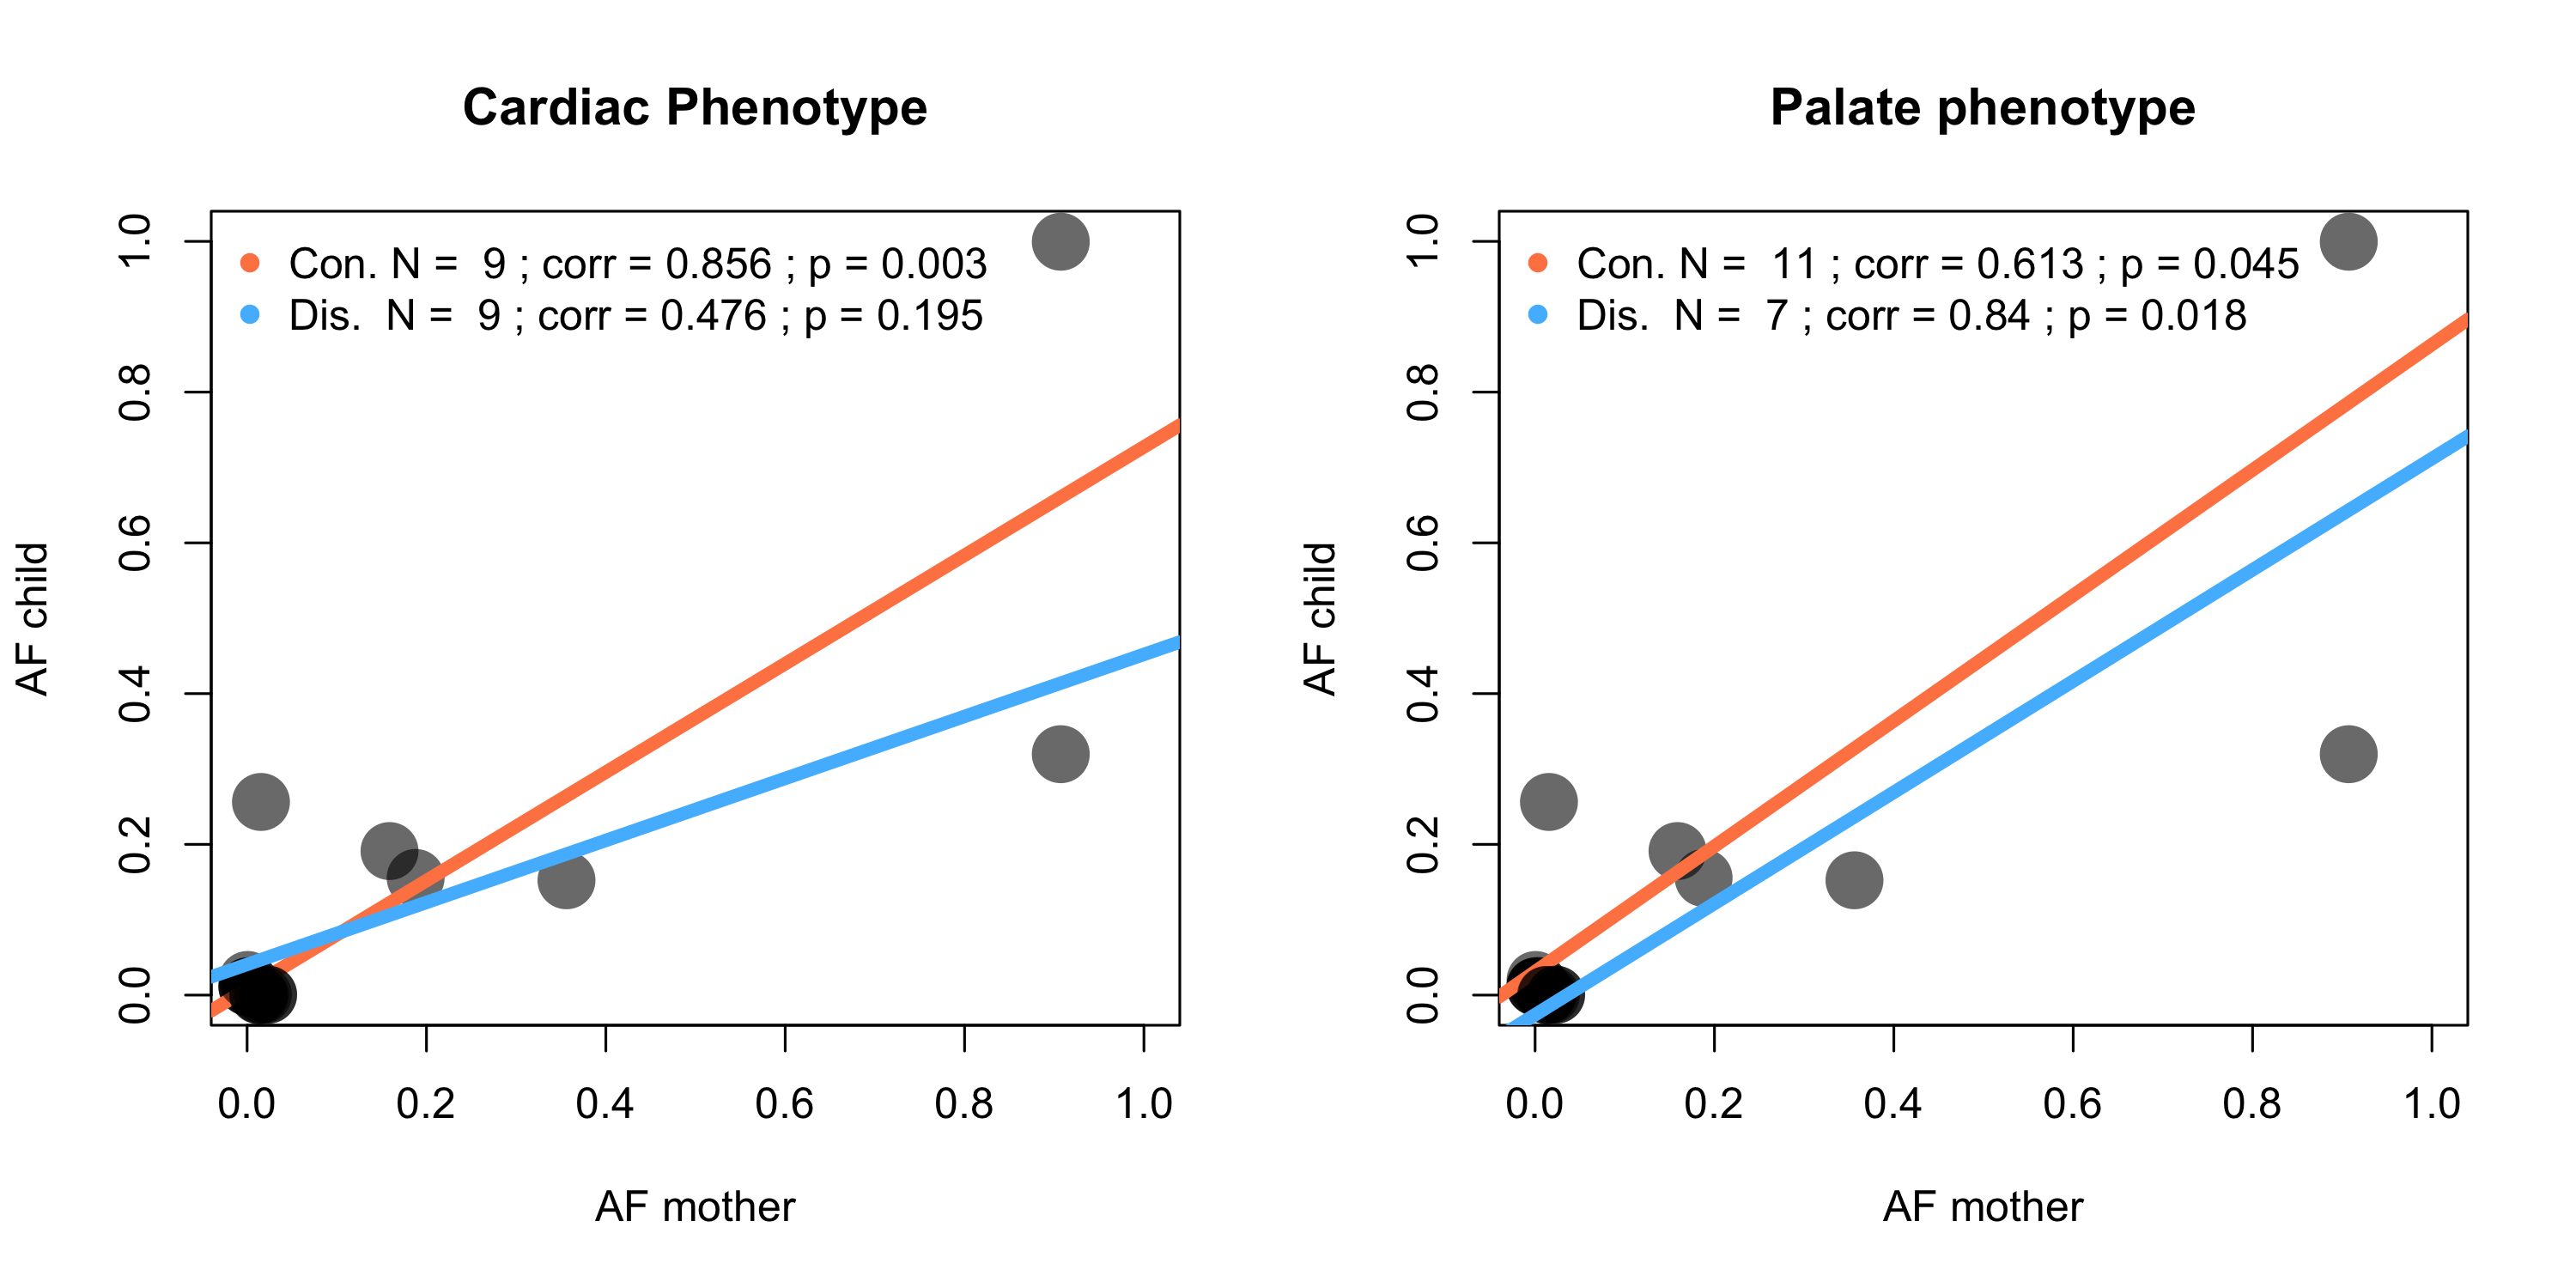

In [68]:
%%R -w 10 -h 5 -u in -r 300
par(mfrow=c(1,2))
#par(mar=c(4,0.5,4,0.5))

plot(x = seq(0,10)/10, y = seq(0,10)/10, type = "n", xlab = "AF mother", ylab = "AF child", main = "Cardiac Phenotype") 

a = final_table[final_table[["heart"]]=="concordant","af_mom"]
b = final_table[final_table[["heart"]]=="concordant","af_child"]
e = round(cor.test(a,b)$estimate, 3)
p = round(cor.test(a,b)$p.value, 3)
leg1 = paste("Con. N = ",length(a), "; corr =", e, "; p =", p)
points(a,b, cex = 3, col = rgb(0,0,0,150, maxColorValue=255), pch = 16)
abline(lm(b ~ a), col = colCon, lwd=5)

a = final_table[final_table[["heart"]]=="discordant","af_mom"]
b = final_table[final_table[["heart"]]=="discordant","af_child"]
e = round(cor.test(a,b)$estimate, 3)
p = round(cor.test(a,b)$p.value, 3)
leg2 = paste("Dis.  N = ",length(a), "; corr =", e, "; p =", p)
points(a,b, cex = 3, col = rgb(0,0,0,150, maxColorValue=255), pch = 16)
abline(lm(b ~ a), col = colDis, lwd=5)

legend(legend=c(leg1,leg2), "topleft", col=c(colCon, colDis), pch = 16, bty="n")

######################

plot(x = seq(0,10)/10, y = seq(0,10)/10, type = "n", xlab = "AF mother", ylab = "AF child", main = "Palate phenotype") 

a = final_table[final_table[["palate"]]=="concordant","af_mom"]
b = final_table[final_table[["palate"]]=="concordant","af_child"]
e = round(cor.test(a,b)$estimate, 3)
p = round(cor.test(a,b)$p.value, 3)
leg1 = paste("Con. N = ",length(a), "; corr =", e, "; p =", p)
points(a,b, cex = 3, col = rgb(0,0,0,150, maxColorValue=255), pch = 16)
abline(lm(b ~ a), col = colCon, lwd=5)

a = final_table[final_table[["palate"]]=="discordant","af_mom"]
b = final_table[final_table[["palate"]]=="discordant","af_child"]
e = round(cor.test(a,b)$estimate, 3)
p = round(cor.test(a,b)$p.value, 3)
leg2 = paste("Dis.  N = ",length(a), "; corr =", e, "; p =", p)
points(a,b, cex = 3, col = rgb(0,0,0,150, maxColorValue=255), pch = 16)
abline(lm(b ~ a), col = colDis, lwd=5)

legend(legend=c(leg1,leg2), "topleft", col=c(colCon, colDis), pch = 16, bty="n")